## Exercise 2

In [1]:
import wrds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
db = wrds.Connection()
db.create_pgpass_file()

Enter your WRDS username [felicity]:alina925
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [4]:
# Download data
aapl=db.raw_sql("select date, ret from crsp.dsf where permco in (7) and date>='2010-01-01' and date<='2020-12-31'")
aapl.to_csv('aapl.csv')

pg=db.raw_sql("select date, ret from crsp.dsf where permco in (21446) and date>='2010-01-01' and date<='2020-12-31'")
pg.to_csv('pg.csv')

In [5]:
aapl = pd.read_csv('aapl.csv', index_col=0)
pg = pd.read_csv('pg.csv', usecols=['ret']).squeeze()

In [8]:
# convert date string to datetime
aapl.date = pd.to_datetime(aapl.date)

# concatenate series into one dataframe
ret = pd.DataFrame({'date': aapl.date, 'aapl': aapl.ret, 'pg':pg})

# set datetime as pd index
ret = ret.set_index('date')

### a)

In [10]:
ret_w = ret.resample('W').sum()

In [16]:
ret_w.describe()

,aapl,pg
count,574.000000,574.000000
mean,0.006027,0.002321
std,0.038903,0.021783
min,-0.180304,-0.110265
25%,-0.017382,-0.009292
50%,0.007690,0.002472
75%,0.029414,0.014700
max,0.143230,0.111966


In [31]:
# expected return
e_ret_aapl = ret_w.mean().aapl * 52
e_ret_pg = ret_w.mean().pg * 52

#std
std_aapl = ret_w.std().aapl * np.sqrt(52)
std_pg = ret_w.std().pg * np.sqrt(52)

#correlation
x = ret_w["aapl"]
y = ret_w["pg"]
coeff = x.corr(y)

print("The expected return of Apple is ", e_ret_aapl, "standard deviation is", std_aapl, "\n")
print("The expected return of P&G is ", e_ret_pg, "standard deviation is", std_pg, "\n")
print("The correlation is", coeff, "\n")

The expected return of Apple is  0.3134186754922118 standard deviation is 0.2805339934064932 

The expected return of P&G is  0.12071312071235513 standard deviation is 0.15708213895976741 

The correlation is 0.32075620422298096 



### b)

In [37]:
# set portfolio weights (also including leverage)
w = np.arange(-0.5,1.6,0.1)

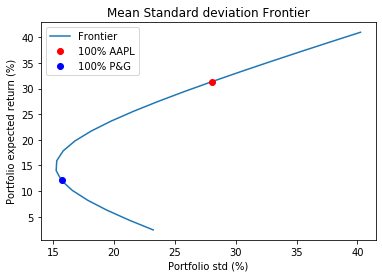

In [61]:
# calculate portfolio return and std
r_p = w * e_ret_aapl + (1-w) * e_ret_pg
std_p = np.sqrt((w*std_aapl)**2 + (1-w)**2*std_pg**2 + 2*w*(1-w)*coeff*std_aapl*std_pg)

#plot
plt.plot(std_p*100,r_p*100,label="Frontier")
plt.xlabel('Portfolio std (%)')
plt.ylabel('Portfolio expected return (%)')
plt.title('Mean Standard deviation Frontier')
plt.plot(std_aapl*100,e_ret_aapl*100,"ro", label="100% AAPL")
plt.plot(std_pg*100,e_ret_pg*100,"bo", label="100% P&G")
plt.legend()
plt.show()

### c)

In [64]:
# to minimize variance
w_min = (std_pg**2 - coeff*std_aapl*std_pg)/(std_aapl**2 + std_pg**2 - 2*coeff*std_aapl*std_pg)

wmin_r_p = w_min * e_ret_aapl + (1-w_min) * e_ret_pg
wmin_std_p = np.sqrt((w_min*std_aapl)**2 + (1-w_min)**2*std_pg**2 + 2*w_min*(1-w_min)*coeff*std_aapl*std_pg)

rf = 0.015
sh = (wmin_r_p - rf)/wmin_std_p

print("The minimum variance portfolio is composed of " ,w_min*100, "% of Apple, and " ,(1-w_min)*100, "% of P&G\n")
print("The expected return is ", wmin_r_p, " The std is ", wmin_std_p, "\n")
print("The Sharpe Ratio is ", sh)




The minimum variance portfolio is composed of  14.033845496618047 % of Apple, and  85.96615450338196 % of P&G

The expected return is  0.14775712053356085  The std is  0.15230108593641728 

The Sharpe Ratio is  0.8716754691360793


### d)

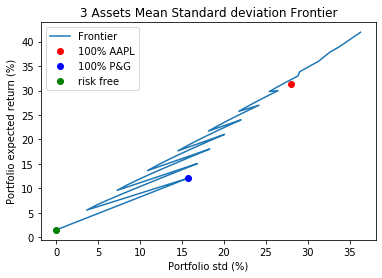

In [101]:
# invest in two risky and one risk free assets
w1 = np.zeros(1)
w2 = np.zeros(1)
for i in range(11):
    temp = np.arange(i/10,1.09,0.1)
    num = len(temp)
    w2 = np.concatenate((w2,temp))
    w1 = np.concatenate((w1,np.ones(len(temp))*i/10))

mixr_p = w1*e_ret_aapl + w2*e_ret_pg + (1-w1-w2)*rf
mixstd_p = np.sqrt((w1*std_aapl)**2 + w2**2*std_pg**2 + 2*w1*w2*coeff*std_aapl*std_pg)

#plot
plt.plot(mixstd_p*100,mixr_p*100,label="Frontier")
plt.xlabel('Portfolio std (%)')
plt.ylabel('Portfolio expected return (%)')
plt.title('3 Assets Mean Standard deviation Frontier')
plt.plot(std_aapl*100,e_ret_aapl*100,"ro", label="100% AAPL")
plt.plot(std_pg*100,e_ret_pg*100,"bo", label="100% P&G")
plt.plot(0,rf*100,"go",label="risk free")
plt.legend()
plt.show()


### e)

In [103]:
from sympy import symbols, solve

In [171]:
# check that the result from solver function is real number
def goodnumber(str):
    try: 
        float(str)
    except TypeError: 
        return False
    return True

In [177]:
# std = 0.2
w1opt = np.zeros(0)
w2opt = np.zeros(0)

for ii in range(1001):
    w1 = ii/1000
    x = symbols('x')
    expr = (w1*std_aapl)**2 + x**2*std_pg**2 + 2*w1*x*coeff*std_aapl*std_pg - 0.2**2
    w2 = solve(expr)
    
    if goodnumber(w2[1]):
        if w1 + w2[1] < 1:
            temp = w2[1]
            w1opt = np.concatenate((w1opt,np.ones(1)*w1))
            w2opt = np.concatenate((w2opt,np.ones(1)*temp))
        

In [197]:
# maximize return with given std
mixr_p = w1opt*e_ret_aapl + w2opt*e_ret_pg + (1-w1opt-w2opt)*rf
maxret = np.amax(mixr_p)
index = np.where(mixr_p == maxret)

print("The optimal weight of Apple is ", w1opt[index]*100, "%\n")
print("The optimal weight of P&G is ", w2opt[index]*100, "%\n")
print("The optimal weight of the risk free is" ,(1-w1opt[index]-w2opt[index])*100, "%\n")

The optimal weight of Apple is  [61.4] %

The optimal weight of P&G is  [38.4742323847997] %

The optimal weight of the risk free is [0.125767615200301] %



In [202]:
# compute risk aversion coefficient
## From the First Order Conditions deriving for Apple:
a = (e_ret_aapl-rf)/(w1opt[index]*std_aapl**2 + w2opt[index]*coeff*std_aapl*std_pg)
print("The value of the risk aversion coefficient is", a)

The value of the risk aversion coefficient is [5.55098285806344]


### f

In [204]:
sharpe = (maxret - rf)/0.2
print("The mean is", maxret, "\nThe Sharpe ratio is", sharpe)


The mean is 0.238901378476313 
The Sharpe ratio is 1.11950689238157
